In [1]:
import os
import pickle

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting (if needed)
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch

from ase.visualize.plot import plot_atoms

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure as PMGStructure
from pymatgen.io.ase import AseAtomsAdaptor

from decifer.utility import pxrd_from_cif

from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties

def get_symbol_patch(latex_input, size=10, center=(0,0), scale=1.0):
    from matplotlib.font_manager import FontProperties
    from matplotlib.textpath import TextPath
    from matplotlib.patches import PathPatch
    from matplotlib.transforms import Affine2D

    # Create a FontProperties object with the desired size
    font_prop = FontProperties(size=size)
    
    # Convert the LaTeX symbol to a TextPath object
    text_path = TextPath(center, latex_input, prop=font_prop)
    
    # Convert the TextPath to a PathPatch object
    patch = PathPatch(text_path, lw=0.01, fc='black')
    
    # Apply a scaling transform to control the patch size in the figure.
    # The 'scale' parameter lets you adjust how large the patch appears.
    patch.set_transform(Affine2D().scale(scale) + patch.get_transform())
    
    return [patch]


def get_compression_arrow(size=0.1, head_length=0.01, center=(0.5, 0.5),
                          mutation_scale=20, color='black'):
    """
    Create a compression arrow composed of three FancyArrowPatch objects.
    
    The compression arrow consists of:
      - A left arrow head pointing inward (rightwards).
      - A shaft (line) connecting the arrow heads.
      - A right arrow head pointing inward (leftwards).
    
    Parameters:
      size : float
          The total horizontal length of the compression arrow.
      head_length : float
          The length of each arrow head.
      center : tuple of float (x, y)
          The center of the arrow.
      mutation_scale : int
          Scale factor for arrow head size.
      color : str
          Color of the arrow.
          
    Returns:
      List of three FancyArrowPatch objects representing the compression arrow.
    """
    cx, cy = center
    left_tip = cx
    right_tip = cx

    # Left arrow head: drawn from left_tip to left_tip + head_length.
    # Using arrowstyle '<-' places the arrow head at the start, i.e. at left_tip, pointing rightwards.
    left_arrow = FancyArrowPatch((left_tip, cy), (left_tip + head_length, cy),
                                 arrowstyle='->', mutation_scale=mutation_scale, color=color)

    # Shaft: a simple line from the end of the left arrow head to the start of the right arrow head.
    shaft = FancyArrowPatch((left_tip, cy), (right_tip + size, cy),
                            arrowstyle='-', mutation_scale=mutation_scale, color=color)

    # Right arrow head: drawn from right_tip to right_tip - head_length.
    # Again, using arrowstyle '<-' places the arrow head at the start (right_tip), 
    # which makes it point leftwards (inward).
    right_arrow = FancyArrowPatch((right_tip + size, cy), (right_tip + size - head_length, cy),
                                  arrowstyle='->', mutation_scale=mutation_scale, color=color)

    return [left_arrow, shaft, right_arrow]

def plot_unit_cell_with_boundaries(structure, ax=None, tol=1e-5, radii=0.8, rotation=('45x, -15y, 90z'), offset=(0, 0, 0)):
    """
    Plots the unit cell along with image atoms from neighboring cells (in the positive x, y, and z directions)
    that are exactly on the unit cell boundary onto a provided axis.
    
    Parameters:
        structure (pymatgen.core.structure.Structure): The input structure.
        ax (matplotlib.axes.Axes): Axis to plot on. If None, a new axis is created.
        tol (float): Tolerance for determining if an atom's fractional coordinate is on the boundary.
        radii (float): Radii for visualizing atoms.
        rotation (tuple or str): Rotation settings for the plot_atoms function.
        
    Returns:
        (ax, discrete_structure): The matplotlib axis containing the plotted structure 
            and the discrete pymatgen Structure constructed.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Define translation vectors for the original cell and its neighboring cells in the positive directions.
    translation_vectors = [
        [0, 0, 0],  # Original cell
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1]
    ]
    
    all_species = []
    all_coords = []
    
    # Loop over each translation vector.
    for tv in translation_vectors:
        tv_cart = structure.lattice.get_cartesian_coords(tv)
        for site in structure:
            if tv == [0, 0, 0]:
                # For the original cell, include all atoms.
                all_species.append(site.species_string)
                all_coords.append(site.coords)
            else:
                # For neighboring cells, include only atoms on the cell boundary
                # (i.e. the atom's fractional coordinate is nearly zero in each shifted direction).
                if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                    all_species.append(site.species_string)
                    all_coords.append(site.coords + tv_cart)
    
    all_coords = np.array(all_coords)
    
    # Build a bounding box that encloses the collected atoms.
    min_coords = all_coords.min(axis=0)
    max_coords = all_coords.max(axis=0)
    lattice_vectors = np.diag(max_coords - min_coords)
    
    discrete_structure = PMGStructure(
        lattice=lattice_vectors,
        species=all_species,
        coords=all_coords,
        coords_are_cartesian=True
    )
    
    # Convert the discrete pymatgen structure to an ASE Atoms object and remove periodic boundaries.
    ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
    ase_atoms.set_pbc([False, False, False])
    
    # Plot onto the provided axis.
    plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation, offset=offset)
    
    return ax, discrete_structure

In [45]:
# Load data
with open('../ablation_results_cubic_crystal_params_comp_2.pkl', "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]

In [46]:
data["config"]["params_dict"]

{'particle_size': [1, 5, 10, 20, 25, 30, 35, 40, 45, 50, 100],
 'peak_asymmetry': [-1.0,
  -0.75,
  -0.5,
  -0.25,
  -0.1,
  0.0,
  0.1,
  0.25,
  0.5,
  0.75,
  1.0],
 'q_shift': [-0.5, -0.25, -0.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.25, 0.5],
 'q_scale': [0.8, 0.9, 0.95, 0.975, 0.99, 1.0, 1.01, 1.025, 1.05, 1.1, 1.2],
 'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'noise': [0.0, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2],
 'base_fwhm': [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4]}

In [3]:
# # Define your list of parameter dictionaries.
# param_keys = [
#     {"key": "q_shift", "xlabel": "Peak Shift", "unit": r"$_{\;[Å^{-1}]}$", "example_1_idx": 2, "example_2_idx": 8},
#     {"key": "q_scale",  "xlabel": "Peak Scale Factor", "unit": "", "example_1_idx": 3, "example_2_idx": 7},
#     {"key": "peak_asymmetry", "xlabel": "Peak Assymetry Factor", "unit": "", "example_1_idx": 0, "example_2_idx": 10},
#     {"key": "particle_size", "xlabel": "Crystallite Size", "unit": r"$_{\;[Å]}$", "example_1_idx": 1, "example_2_idx": 8},
#     {"key": "eta", "xlabel": "Mixture Coefficient", "unit": "", "example_1_idx": 1, "example_2_idx": 8},
#     {"key": "noise", "xlabel": "Additive Noise", "unit": "%", "example_1_idx": 1, "example_2_idx": 10},
#     # {"key": "base_fwhm", "xlabel": "Instrumental Broadening", "unit": "", "example_1_idx": 1, "example_2_idx": 6},
# ]

# # Colors
# c_ex1 = "k"#"C1"
# c_ex2 = "k"#"C2"
# c_pred1 = "C3"#"grey"
# c_pred2 = "C3"#"grey"
# c_trend = "k"#"C3"

# # Other
# pred_marker_size = 3
# fig_width_factor = 3

# n_params = len(param_keys)
# # Create a subplot grid with 3 rows:
# # Row 0: main plot; Row 1: trend plot; Rows 2: unit cell plots for example A
# # Use height_ratios so that rows 2 and 3 are half the height of rows 0 and 1.
# fig, axes = plt.subplots(4, n_params, figsize=(fig_width_factor * n_params, 10), squeeze=False,
#                           sharey='row', gridspec_kw={'height_ratios': [1, 1, 0.25, 0.7]})

# for i, param in enumerate(param_keys):
#     param_key = param["key"]
#     param_key_xlabel = param["xlabel"]
#     param_key_unit = param["unit"]

#     param_val_keys = list(results[param_key].keys())
#     example_1_idx = param["example_1_idx"]
#     example_2_idx = param["example_2_idx"]
#     example_1_key = param_val_keys[example_1_idx]
#     example_2_key = param_val_keys[example_2_idx]
    
#     # --- Top subplot: main plot for current parameter.
#     ax = axes[0, i]
#     # Extract data for example 1 (A)
#     q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
#     iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
#     q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
#     iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
#     # Extract data for example 2 (B)
#     q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
#     iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
#     q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
#     iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
#     peak_scaling = 0.8
#     ax.plot(q_1, iq_1 * peak_scaling, lw=1, c=c_ex1, label='input')
#     ax.plot(q_100, iq_100 * peak_scaling - 1, lw=1, c=c_ex2)
    
#     #ax.bar(q_1_disc, iq_1_disc / 100 * peak_scaling, width=pred_width, color=c_pred1, zorder=10, label='pred. 1', hatch='..', edgecolor='none')
#     #ax.bar(q_100_disc, iq_100_disc / 100 * peak_scaling, bottom=-1, width=pred_width, color=c_pred2, zorder=10, label='pred. 2', hatch='..', edgecolor='none')

#     stem = ax.stem(q_1_disc,  iq_1_disc / 100 * peak_scaling, linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', label='prediction')  # 'k' for black color
#     stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=1.0)
#     stem.markerline.set_xdata(q_1_disc)

#     stem = ax.stem(q_100_disc, iq_100_disc / 100 * peak_scaling - 1, linefmt=f'{c_pred2}-', markerfmt=f'{c_pred2}o', basefmt=' ', bottom=-1)  # 'k' for black color
#     stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred2}', markeredgewidth=1.0)
#     stem.markerline.set_xdata(q_100_disc)
    
#     ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3,
#                 frameon=False, columnspacing=0.0, handletextpad=0.15)
    
#     ax.grid(alpha=0.2)
#     ax.set(
#         yticklabels=[],
#         xlabel=r"$Q_{\;[Å^{-1}]}$",
#         ylabel=r"$I(Q)_{\;[a.u.]}$" if i == 0 else "",
#         ylim=(-1.05, None),
#         xlim=(1, 8),
#     )

#     ax.set_title(param_key_xlabel, pad=20.0, fontsize=12)
    
#     ax.text(1.5, 0.5, "A", ha='center', va='top', fontsize=12, color='black',
#             path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax.text(1.5, -0.5, "B", ha='center', va='top', fontsize=12, color='black',
#             path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
#     # --- Second subplot: trend plot for current parameter.
#     ax_t = axes[1, i]
#     min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
#     mean_rwps = np.array([np.mean([l["rwp"] for l in results[param_key][key]["experiments"]])
#                             for key in param_val_keys])
#     std_rwps = np.array([np.std([l["rwp"] for l in results[param_key][key]["experiments"]])
#                            for key in param_val_keys])
    
#     ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color=c_trend)
#     ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}(R_{\mathrm{wp}})$", color=c_trend, s=10, fc='white', zorder=10)
#     ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps,
#                       color=c_trend, alpha=0.2, ec='none')
    
#     ax_t.axvline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
#     ax_t.axvline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
#     ax_t.grid(alpha=0.2, which='major')
    
#     letter_pos = 0.2
#     y_top = ax_t.get_ylim()[1]
#     ax_t.text(example_1_idx, y_top * letter_pos, "A", ha='center', va='top', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax_t.text(example_2_idx, y_top * letter_pos, "B", ha='center', va='top', fontsize=12, color='black',
#               path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
#     ax_t.set(
#         ylabel=r'$R_{\mathrm{wp}}$' if i == 0 else "",
#         xlabel=f'{param_key_xlabel}{param_key_unit}'
#     )
#     ax_t.set_xticks(list(param_val_keys))
#     ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
#     ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=2,
#                 frameon=False, columnspacing=0.0, handletextpad=0.15)
    
#     # --- Third subplot (new row): Horizontal boxplots of combined cell side lengths for current parameter.
#     ax_box = axes[2, i]
    
#     # Gather cell side lengths from all experiments for both structures.
#     # For structure A:
#     experiments_A = results[param_key][example_1_key]["experiments"]
#     cell_params_A = np.array([exp["generated_structure"].lattice.abc for exp in experiments_A])
#     data_A = cell_params_A.flatten()  # Combine a, b, and c values
    
#     # For structure B:
#     experiments_B = results[param_key][example_2_key]["experiments"]
#     cell_params_B = np.array([exp["generated_structure"].lattice.abc for exp in experiments_B])
#     data_B = cell_params_B.flatten()  # Combine a, b, and c values
    
#     # Create a horizontal boxplot with two boxes: one for structure A and one for structure B.
#     data = [data_B, data_A]
#     labels = ["B", "A"]
#     bp = ax_box.boxplot(data, widths=0.5, patch_artist=True, showfliers=False, vert=False)
    
#     # Color the boxplots in greyscale: dark grey for A and light grey for B.
#     colors = ['0.3', '0.7']
#     handles = []  # Store legend handles explicitly
    
#     for j, box in enumerate(reversed(bp['boxes'])):
#         box.set(facecolor=colors[j])
#         handles.append(box)  # Collect handles in reversed order
    
#     # For horizontal boxplots, set y-ticks to label the two groups.
#     ax_box.set_yticks([])
#     ax_box.set_yticklabels([])

#     # Compute reference means for each structure using the best experiment's generated structure.
#     ref_structure_A = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
#     ref_cell_A = np.array(ref_structure_A.lattice.abc)
#     ref_mean_A = ref_cell_A.mean()
    
#     ref_structure_B = results[param_key][example_2_key]["best_experiment"]["reference_structure"]
#     ref_cell_B = np.array(ref_structure_B.lattice.abc)
#     ref_mean_B = ref_cell_B.mean()
    
#     # Draw dotted vertical lines for the reference means.
#     hline = ax_box.axvline(ref_mean_A, color=colors[0], linestyle=':', linewidth=1, c='C3', label='ref.')
#     handles.append(hline)
#     ax_box.axvline(ref_mean_B, color=colors[1], linestyle=':', linewidth=1, c='C3')

#     ax_box.set_xlabel(r"Cell Length Prediction$_{\;[Å]}$")
#     ax_box.grid(alpha=0.2)
    
#     # Ensure A appears before B in the legend
#     ax_box.legend(handles=handles, labels=['A', 'B', 'ref.'], fontsize=9, loc='upper center',
#                   bbox_to_anchor=(0.5, 1.6), ncol=3, frameon=False, columnspacing=1.0, handletextpad=0.25)
    
#     # --- Fourth subplot (shifted down): Unit cell plot including both mean structures A and B.
#     # For structure A, select from all experiments using the mean rwp.
#     rwp_values_A = np.array([exp["rwp"] for exp in experiments_A])
#     mean_rwp_A = np.mean(rwp_values_A)
#     closest_idx_A = np.argmin(np.abs(rwp_values_A - mean_rwp_A))
#     structure_A = experiments_A[closest_idx_A]["generated_structure"]
    
#     # For structure B, similarly select the experiment closest to the mean rwp.
#     rwp_values_B = np.array([exp["rwp"] for exp in experiments_B])
#     mean_rwp_B = np.mean(rwp_values_B)
#     closest_idx_B = np.argmin(np.abs(rwp_values_B - mean_rwp_B))
#     structure_B = experiments_B[closest_idx_B]["generated_structure"]
    
#     ax_cell = axes[3, i]
#     # Plot structure A with no offset.
#     ax_cell, discrete_structure_A = plot_unit_cell_with_boundaries(structure_A, ax=ax_cell)
    
#     # Compute an offset for structure B based on structure A's lattice parameter.
#     a_A, _, _ = discrete_structure_A.lattice.abc
#     offset_B = (a_A * 2, 0, 0)
    
#     # Plot structure B on the same axis with the computed offset.
#     ax_cell, discrete_structure_B = plot_unit_cell_with_boundaries(structure_B, ax=ax_cell, offset=offset_B)
    
#     # Add text labels at appropriate data coordinates.
#     ax_cell.text(0, 0, r"$\overline{\mathbf{A}}$", fontsize=12, fontweight='bold', color='black',
#                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
#     ax_cell.text(offset_B[0], 0,  r"$\overline{\mathbf{B}}$", fontsize=12, fontweight='bold', color='black',
#                  path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
#     ax_cell.set_ylim(-2, discrete_structure_B.cart_coords.max()*2)
#     ax_cell.axis("off")

# fig.subplots_adjust(hspace=0.6, wspace=0.1)

# # Shift the third row
# for ax in axes[2]:
#     pos = ax.get_position()
#     ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])

# fig.savefig("the_figure.png", dpi=300, bbox_inches='tight')
# plt.show()


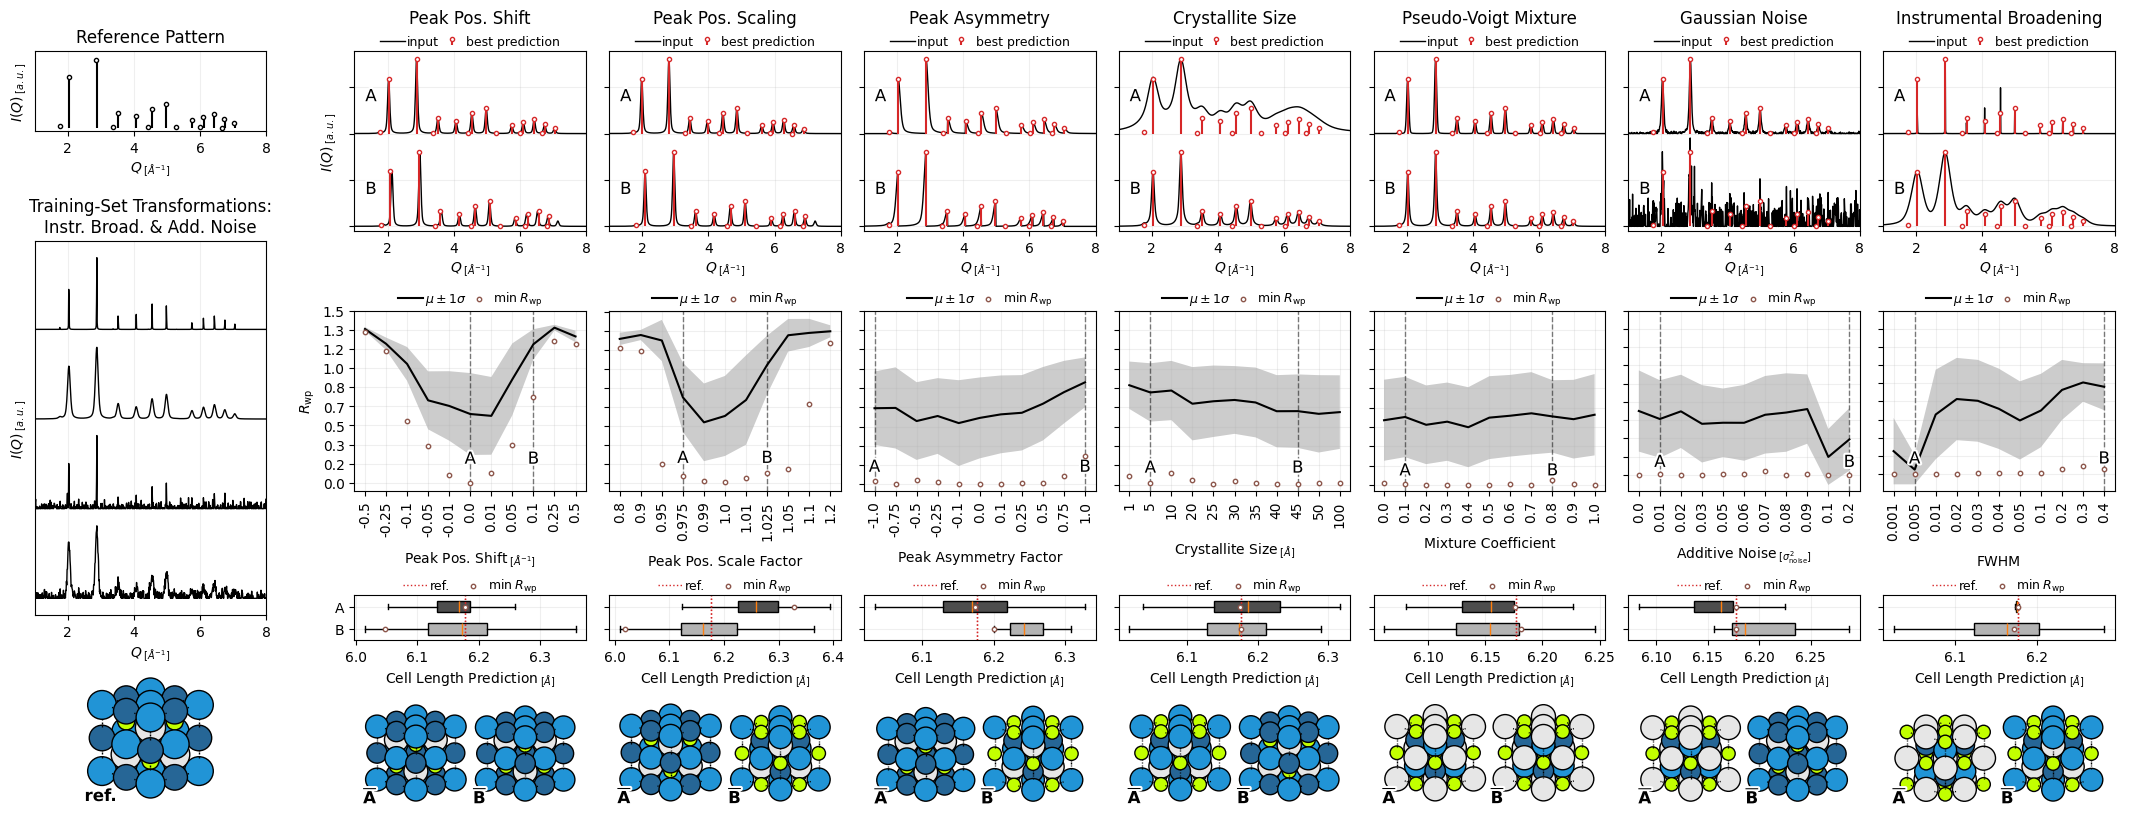

In [52]:
# Define your list of parameter dictionaries.
compression_args = dict(size=0.3, head_length=0.001, mutation_scale=10, color='black')

param_keys = [
    {
        "key": "q_shift", 
        "title": "Peak Pos. Shift", 
        "xlabel": "Peak Pos. Shift", 
        "unit": r"$_{\;[Å^{-1}]}$", 
        "example_1_idx": 5, 
        "example_2_idx": 8,
        "param_symbol_top": r"$\lhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\rhd\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "q_scale", 
        "title": "Peak Pos. Scaling", 
        "xlabel": "Peak Pos. Scale Factor", 
        "unit": "", 
        "example_1_idx": 3, 
        "example_2_idx": 7,
        "param_symbol_top": r"$\rhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\lhd\;\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry Factor", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 10,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
    {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "eta", 
        "title": "Pseudo-Voigt Mixture", 
        "xlabel": "Mixture Coefficient", 
        "unit": "", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "param_symbol_top": r"$\cap$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\prec$",
        "param_symbol_bot_rot": -90,
        "param_symbol_size": 12
    },
    {
        "key": "noise", 
        "title": "Gaussian Noise", 
        "xlabel": "Additive Noise", 
        "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 10,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "base_fwhm", 
        "title": "Instrumental Broadening", 
        "xlabel": "FWHM", 
        "unit": "", 
        "example_1_idx": 1, 
        "example_2_idx": 10,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    
    # {"key": "base_fwhm", "xlabel": "Instrumental Broadening", "unit": "", "example_1_idx": 1, "example_2_idx": 6},
]

# Colors
c_ex1 = "k"#"C1"
c_ex2 = "k"#"C2"
c_pred1 = "C3"#"grey"
c_pred2 = "C3"#"grey"
c_trend = "k"#"C3"
c_min = "C5"

# Other
pred_marker_size = 3
fig_width_factor = 3.25

n_params = len(param_keys)
# Create a subplot grid with 3 rows:
# Row 0: main plot; Row 1: trend plot; Rows 2: unit cell plots for example A
# Use height_ratios so that rows 2 and 3 are half the height of rows 0 and 1.
fig, axes = plt.subplots(4, n_params + 1, figsize=(fig_width_factor * (n_params + 1), 10), squeeze=False,
                          gridspec_kw={'height_ratios': [1, 1, 0.25, 0.7]}) # sharey='row'

for i, param in enumerate(param_keys):
    param_key = param["key"]
    param_key_title = param["title"]
    param_key_xlabel = param["xlabel"]
    param_key_unit = param["unit"]
    param_symbol_top = param["param_symbol_top"]
    param_symbol_top_rot = param["param_symbol_top_rot"]
    param_symbol_bot = param["param_symbol_bot"]
    param_symbol_bot_rot = param["param_symbol_bot_rot"]
    param_symbol_size = param["param_symbol_size"]

    param_val_keys = list(results[param_key].keys())
    example_1_idx = param["example_1_idx"]
    example_2_idx = param["example_2_idx"]
    example_1_key = param_val_keys[example_1_idx]
    example_2_key = param_val_keys[example_2_idx]
    
    # --- Top subplot: main plot for current parameter.
    ax = axes[0, i + 1]
    # Extract data for example 1 (A)
    q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    # Extract data for example 2 (B)
    q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    peak_scaling = 0.8
    ax.plot(q_1, iq_1 * peak_scaling, lw=1, c=c_ex1, label='input')
    ax.plot(q_100, iq_100 * peak_scaling - 1, lw=1, c=c_ex2)

    stem = ax.stem(q_1_disc,  iq_1_disc / 100 * peak_scaling, linefmt=f'{c_pred1}-', markerfmt=f'{c_pred1}o', basefmt=' ', label='best prediction')  # 'k' for black color
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred1}', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_1_disc)

    stem = ax.stem(q_100_disc, iq_100_disc / 100 * peak_scaling - 1, linefmt=f'{c_pred2}-', markerfmt=f'{c_pred2}o', basefmt=' ', bottom=-1)  # 'k' for black color
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_pred2}', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_100_disc)
    
    ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3,
                frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    ax.grid(alpha=0.2)
    ax.set(
        yticklabels=[],
        xlabel=r"$Q_{\;[Å^{-1}]}$",
        ylabel=r"$I(Q)_{\;[a.u.]}$" if i == 0 else "",
        ylim=(-1.05, None),
        xlim=(1, 8),
    )

    ax.set_title(param_key_title, pad=20.0, fontsize=12)
    
    ax.text(1.5, 0.5, "A", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax.text(1.5, -0.5, "B", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

    # ax.text(7.0, 0.5, param_symbol_top, ha='center', va='top', fontsize=param_symbol_size, color='black', rotation=param_symbol_top_rot,
    #         path_effects=[path_effects.withStroke(linewidth=0.0, foreground='black')])
    # ax.text(7.0, -0.5, param_symbol_bot, ha='center', va='top', fontsize=param_symbol_size, color='black', rotation=param_symbol_bot_rot,
    #         path_effects=[path_effects.withStroke(linewidth=0.0, foreground='black')])
    
    # --- Second subplot: trend plot for current parameter.
    ax_t = axes[1, i + 1]
    min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
    mean_rwps = np.array([np.mean([l["rwp"] for l in results[param_key][key]["experiments"]])
                            for key in param_val_keys])
    std_rwps = np.array([np.std([l["rwp"] for l in results[param_key][key]["experiments"]])
                           for key in param_val_keys])
    
    ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color=c_trend)
    ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}\;R_{\mathrm{wp}}$", color=c_min, s=10, fc='white', zorder=10)
    ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps,
                      color=c_trend, alpha=0.2, ec='none')
    
    ax_t.axvline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
    ax_t.axvline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
    ax_t.grid(alpha=0.2, which='major')
    
    letter_pos = 0.2
    y_top = ax_t.get_ylim()[1]
    ax_t.text(example_1_idx, y_top * letter_pos, "A", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_t.text(example_2_idx, y_top * letter_pos, "B", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_t.set_ylabel(r'$R_{\mathrm{wp}}$' if i == 0 else "")
    ax_t.set_xlabel(f'{param_key_xlabel}{param_key_unit}', labelpad=10.0)
    ax_t.set_xticks(list(param_val_keys))
    ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
    ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=2,
                frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    # --- Third subplot (new row): Horizontal boxplots of combined cell side lengths for current parameter.
    ax_box = axes[2, i + 1]
    
    # Gather cell side lengths from all experiments for both structures.
    # For structure A:
    experiments_A = results[param_key][example_1_key]["experiments"]
    cell_params_A = np.array([exp["generated_structure"].lattice.abc for exp in experiments_A])
    data_A = cell_params_A.flatten()  # Combine a, b, and c values

    # Best cell params in A
    best_cell_params_A = results[param_key][example_1_key]["best_experiment"]["generated_structure"].lattice.abc
    mean_best_data_A = np.mean(best_cell_params_A)
    
    # For structure B:
    experiments_B = results[param_key][example_2_key]["experiments"]
    cell_params_B = np.array([exp["generated_structure"].lattice.abc for exp in experiments_B])
    data_B = cell_params_B.flatten()  # Combine a, b, and c values

    # Best cell params in B
    best_cell_params_B = results[param_key][example_2_key]["best_experiment"]["generated_structure"].lattice.abc
    mean_best_data_B = np.mean(best_cell_params_B)
    
    # Create a horizontal boxplot with two boxes: one for structure A and one for structure B.
    data = [data_B, data_A]
    labels = ["B", "A"]
    bp = ax_box.boxplot(data, widths=0.5, patch_artist=True, showfliers=False, vert=False)
    
    # Color the boxplots in greyscale: dark grey for A and light grey for B.
    colors = ['0.3', '0.7']
    handles = []  # Store legend handles explicitly
    
    for j, box in enumerate(reversed(bp['boxes'])):
        box.set(facecolor=colors[j])
    #     handles.append(box)  # Collect handles in reversed order
    
    # For horizontal boxplots, set y-ticks to label the two groups.
    if i + 1 == 1:
        ax_box.set_yticks([1,2])
        ax_box.set_yticklabels(["B", "A"])
    else:
        ax_box.set_yticks([1,2])
        ax_box.set_yticklabels([])

    # Compute reference means for each structure using the best experiment's generated structure.
    ref_structure_A = results[param_key][example_1_key]["best_experiment"]["reference_structure"]
    ref_cell_A = np.array(ref_structure_A.lattice.abc)
    ref_mean_A = ref_cell_A.mean()
    
    ref_structure_B = results[param_key][example_2_key]["best_experiment"]["reference_structure"]
    ref_cell_B = np.array(ref_structure_B.lattice.abc)
    ref_mean_B = ref_cell_B.mean()
    
    # Draw dotted vertical lines for the reference means.
    hline = ax_box.axvline(ref_mean_A, color=colors[0], linestyle=':', linewidth=1, c='C3')
    handles.append(hline)
    ax_box.axvline(ref_mean_B, color=colors[1], linestyle=':', linewidth=1, c='C3')

    # Add mean of bests
    mbA = ax_box.scatter(x=mean_best_data_A, y=2, ec=c_min, zorder=10, s=10, fc='white')
    ax_box.scatter(x=mean_best_data_B, y=1, ec=c_min, zorder=10, s=10, fc='white')
    handles.append(mbA)
    
    ax_box.set_xlabel(r"Cell Length Prediction$_{\;[Å]}$")
    ax_box.grid(alpha=0.2)

    # Ensure A appears before B in the legend
    ax_box.legend(handles=handles, labels=['ref.', r"$\mathrm{min}\;R_{\mathrm{wp}}$"], fontsize=9, loc='upper center',
                  bbox_to_anchor=(0.5, 1.65), ncol=4, frameon=False, columnspacing=0.85, handletextpad=0.15)
    
    # --- Fourth subplot (shifted down): Unit cell plot including both mean structures A and B.
    # For structure A, select from all experiments using the mean rwp.
    rwp_values_A = np.array([exp["rwp"] for exp in experiments_A])
    mean_rwp_A = np.mean(rwp_values_A)
    closest_idx_A = np.argmin(np.abs(rwp_values_A - mean_rwp_A))
    structure_A = experiments_A[closest_idx_A]["generated_structure"]
    
    # For structure B, similarly select the experiment closest to the mean rwp.
    rwp_values_B = np.array([exp["rwp"] for exp in experiments_B])
    mean_rwp_B = np.mean(rwp_values_B)
    closest_idx_B = np.argmin(np.abs(rwp_values_B - mean_rwp_B))
    structure_B = experiments_B[closest_idx_B]["generated_structure"]
    
    ax_cell = axes[3, i + 1]
    # Plot structure A with no offset.
    ax_cell, discrete_structure_A = plot_unit_cell_with_boundaries(structure_A, ax=ax_cell)
    
    # Compute an offset for structure B based on structure A's lattice parameter.
    a_A, _, _ = discrete_structure_A.lattice.abc
    offset_B = (a_A * 2, 0, 0)
    
    # Plot structure B on the same axis with the computed offset.
    ax_cell, discrete_structure_B = plot_unit_cell_with_boundaries(structure_B, ax=ax_cell, offset=offset_B)
    
    # Add text labels at appropriate data coordinates.
    ax_cell.text(0, 0, r"$\overline{\mathbf{A}}$", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_cell.text(offset_B[0], 0,  r"$\overline{\mathbf{B}}$", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_cell.set_ylim(-2, discrete_structure_B.cart_coords.max()*2)
    ax_cell.axis("off")

fig.subplots_adjust(hspace=0.6, wspace=0.1)

# yticks for Rwp
for ax in axes[1,1:]:
    ax.set_yticks(np.linspace(0,1.5,10))
    ax.set_yticklabels([])
axes[1,1].set_yticks(np.linspace(0,1.5,10))
axes[1,1].set_yticklabels(["{:.1f}".format(e) for e in np.linspace(0,1.5,10)])

# Shift the third row
for ax in axes[2]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 - 0.025, pos.width, pos.height])

# Reference shift
ref_shift = 0.025

# Shift the new left column further to the left
for row in range(4):
    ax = axes[row, 0]
    pos = ax.get_position()
    # Adjust the x0 position to shift left by 0.05 (adjust value as needed)
    ax.set_position([pos.x0 - 0.05, pos.y0, pos.width, pos.height])

# Combine rows 2 and 3 for the left column into a single axis.
# Get the gridspec from one of the left column axes.
gs = axes[0, 0].get_gridspec()

# Remove the existing left column axes for rows 2 and 3.
for ax in axes[:, 0]:
    ax.remove()

ax_p = fig.add_subplot(gs[0,0])

# Create a new axis spanning rows 2 and 3 in the first column.
ax_ref_struc = fig.add_subplot(gs[-1, 0])
    
pos = ax_ref_struc.get_position()
ax_ref_struc.set_position([pos.x0 - ref_shift, pos.y0 + 0.02, pos.width, pos.height])

# Add reference structure to ax_ref_struc
ax_ref_struc, _ = plot_unit_cell_with_boundaries(ref_structure_A, ax=ax_ref_struc, offset=(0,0,0))
ax_ref_struc.text(0, 0, "ref.", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
ax_ref_struc.axis("off")

ax_p.set_title("Reference Pattern", fontsize=12)

param_val_keys = list(results[param_keys[0]["key"]].keys())
q_ref_disc = results[param_keys[0]["key"]][param_val_keys[param_keys[0]["example_1_idx"]]]["best_experiment"]["pxrd_ref_clean"]["q_disc"][0]
iq_ref_disc = results[param_keys[0]["key"]][param_val_keys[param_keys[0]["example_2_idx"]]]["best_experiment"]["pxrd_ref_clean"]["iq_disc"][0]

peak_scaling = 0.8
stem = ax_p.stem(q_ref_disc, iq_ref_disc / 100 * peak_scaling, linefmt=f'{c_trend}-', markerfmt=f'{c_trend}o', basefmt=' ')
stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=f'{c_trend}', markeredgewidth=1.0)
stem.markerline.set_xdata(q_ref_disc - 0.01)
pos = ax_p.get_position()
ax_p.set_position([pos.x0 - ref_shift, pos.y0 + 0.1, pos.width, pos.height - 0.1])
ax_p.set(
    yticks=[],
    yticklabels=[],
    xlim=(1,8),
    ylim=(None, peak_scaling+0.1),
    ylabel=r"$I(Q)_{\;[a.u.]}$",
    xlabel=r"$Q_{\;[Å^{-1}]}$",
)
ax_p.grid(alpha=0.2)

ax_ref_trans = fig.add_subplot(gs[1:-1, 0])
pos = ax_ref_trans.get_position()
ax_ref_trans.set_position([pos.x0 - ref_shift, pos.y0, pos.width, pos.height + 0.07])
ax_ref_trans.set(
    yticks=[],
    yticklabels=[],
    xlim=(1,8),
    ylabel=r"$I(Q)_{\;[a.u.]}$",
    xlabel=r"$Q_{\;[Å^{-1}]}$",
)
ax_ref_trans.grid(alpha=0.2)
ax_ref_trans.set_title("Training-Set Transformations:\nInstr. Broad. & Add. Noise")

# Calculate PXRD from reference
pxrds_ref = []
for fwhm, noise in zip([0.01, 0.10, 0.01, 0.10], 
                       [0.00, 0.00, 0.05, 0.05]):
    cif = results[param_keys[0]["key"]][param_val_keys[param_keys[0]["example_1_idx"]]]["best_experiment"]["reference_cif"]
    pxrds_ref.append(pxrd_from_cif(cif, base_fwhm=fwhm, noise=noise))

for i,pxrd in enumerate(pxrds_ref):
    ax_ref_trans.plot(pxrd["q"], pxrd["iq"]*peak_scaling-i, c='k', lw=1)

fig.savefig("the_figure.pdf", dpi=300, bbox_inches='tight')
plt.show()
